# Assignment 1: filtering of deterministic signals

This tutorial investigates deterministic signals and the behavior of filters.

**Important:** *Please provide clear and details explanations
for you answers (not only code but text/equations showing
your reasoning to answer the questions). Details response can either be typed or handwritten on a document that you could scan.*

To do this assignement we need a Python 3 distribution with the following libraries:

In [1]:
# import numpy for array manipulation and fft
import numpy as np
#import classical constant pi form numpy to avoid namespace
from numpy import pi
# import filtering functionalities from scipy.signal
from scipy.signal import lfilter, filtfilt, butter, freqs, freqz, iirfilter, lfilter_zi
# import solver for differential equations
from scipy.integrate import odeint, ode
# plotting functionalities
import matplotlib.pyplot as plt


If you want to give back the assignement as a jupyter notebook, the following command triggers inline plot.

In [2]:
%matplotlib inline

### Basic representation of signals
This paragraph is just a refresher of conventions that were already used during the tutorial.

We will use a numerical representation of signals, we will assume the following setting:

 - signals are sampled at sampling period $dt$ seconds
 - as a consequence, the sampling frequency is $F$ is $1/dt$ Hz

Here is a basic example of how to plot the representation of a continuous time signal ($\cos(2\pi t)$) by its sampled version in numpy:

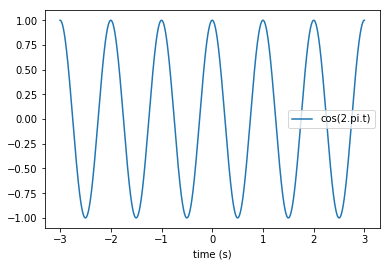

In [3]:
from numpy import pi
# define sampling frequency
dt=.001;
# define time axis
t = np.arange(-3,3,dt)
# sample a continuous function, e.g. 1-periodic cosine at these time points
x = np.cos(2*pi*t)
plt.plot(t,x)
plt.xlabel('time (s)')
plt.legend(['cos(2.pi.t)'])

If we want to plot the discretized signal for what it is, i.e. a finite sequence of numbers, we can use stem, however this is easy to visualize only for few samples

<StemContainer object of 3 artists>

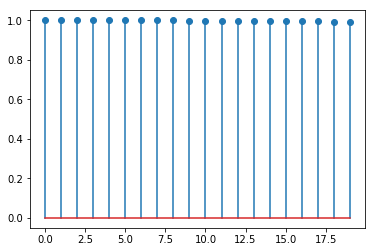

In [4]:
plt.stem(x[0:20])

Alternatively we can just use the plot function, and only the x-axis changes

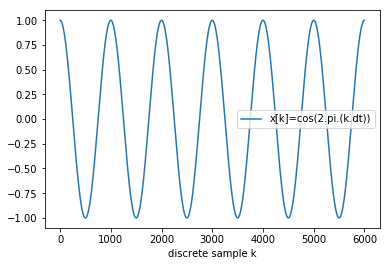

In [5]:
plt.plot(x)
plt.xlabel('discrete sample k')
plt.legend(['x[k]=cos(2.pi.(k.dt))'])

## Modeling of post-synaptic potentials (PSP)

We will study a linear model of the post-synaptic potential of a neuronal membrane. The pre-synaptic input to this neuron will be denoted $x(t)$, and the output membrane potential $y(t)$. 

We use a first order differential equation to model the input output relationship. This relies neglecting many non-linearities, and assuming $x(t)$ directly reflects the post-synaptic current flowing through the membrane with capacitance $C$ (due to charge accumulation on both sides of the membrane) and resistance $R$ (modeling the leak currents flowing through various ion channels).

This results in the differential equation:

$$C\frac{dy}{dt}(t)+\frac{1}{R}y(t)= x(t)$$

To simplify notation we will assume $R=1$ such that the above equation is only controlled by the membrane time constant $\tau=RC$ and can be rewritten

$$\tau\frac{dy}{dt}(t)+y(t)= x(t)$$



# Part 1: analog filter

## Simulation with ODE solver

Such ordinary differential equation (ODE) can be simulated on a computer using scipy.integrate.ode, which is a wrapper for solving initial value problems of dynamical systems. To apply such routine, we put the equation in the form

$$\frac{dy}{dt}(t)= \frac{1}{\tau}\left(x(t)-y(t)\right)=f_x(y,t)$$

such that we can estimate the response to different inputs $x(t)$ by redefining the function $f_x$. We define this function with $\tau=20ms$, such that we can pass an arbitrary function of time for $x$ as third argument:

In [6]:
tau = .02
def f_x(t,y,x):
    return 1/tau*(x(t)-y)

In addition, to the differential equation, solving for $y$ requires providing an initial value $y_0$ such that $y(t_0)=y_0$ for a given initial time point $t_0$. In order to unambiguously define the output of the system without further consideration for this initial value, we will always assume $y_0=0$ and choose $t_0$ such that $x(t)=0$ for all $t<t_0$. Under such assumption, the output of the system is a signal $y(t)$ such that $y(t)=0$ for all $t<t_0$, and for $t\geq t_0$, $y(t)$ is provided by the solution of the initial value problem defined above.

We will take for granted that the output $y$ can be computed for time axis $t$ using the  *filterOutput* function defined below:

In [7]:
def filterOutput(t,x):
    '''
    computes output values for the synapse model
    inputs:
        t - a 1 dimensional numpy array of time points at which values should be computed
        x - a function take one float input argument (the time)
    outputs:
        y - a 1 diensional numpy array of values of y(t) for each input time point
    '''
    r = ode(f_x,None)
    r.set_integrator('dopri5')
    r.set_initial_value(0,t[0])
    r.set_f_params(x)
    y = []
    for k in range(t.shape[0]):
        y.append(r.integrate(r.t+dt))
    return np.array(y)


The post-synaptic response in real neurons is triggered afferent (pre-synaptic) action potentials. To model this, we define a triangular spike waveform parameterized by a spike width T (in seconds).

In [8]:
def spikeWaveform(t,T):
    spkWave = (np.abs(t)<T).astype(np.float)*(1-np.abs(t)/T)/T
    return spkWave


We will assume a spike duration of $1ms$ and fix the spike(t) function accordingly

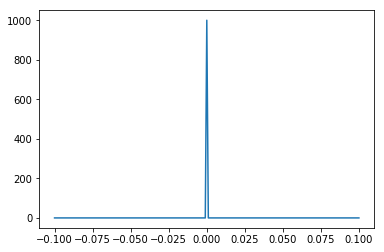

In [50]:
T = .001
dt=.0001
spike = lambda t: spikeWaveform(t,T)
t=np.arange(-.1,.1,dt)
plt.plot(t,spike(t))

**Question 1:**

 - (a) Compute the response of the above defined synapse to spike(t), using the above function, for a time axis ranging from $-10ms$ to $100ms$, with a sampling period $dt=0.1ms$ (unless otherwise stated, $dt$ takes this value for all other questions).
 - (b) From the lecture, find the analytical expression of the impulse response of the system with input x and output y, plot this response.
 - (c) Compare plots in (a) and (b), and based on that argue which well know distribution  $spike(t)$ approximates in the context of this simulation.
 - (d) We define the *current clamp* experiments as setting $x(t)= 1$ (from an original value of $0$ for $t<0$) for the duration $0\leq t\leq D$ with $D=100ms$, before setting back $x(t)=0$ for $t>D$. Compute and plot the output y(t) for such experiment for t ranging from $-10ms$ to $200ms$.

# 1-(a)

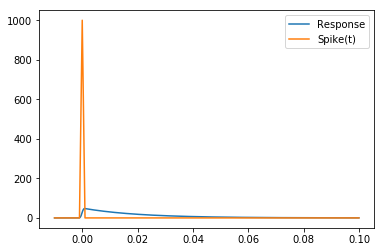

In [54]:
t=np.arange(-.01,.1,dt);
spike = lambda t: spikeWaveform(t,T);
h_t_fo = filterOutput(t, spike);
plt.plot(t,h_t_fo, label = 'Response');
plt.plot(t,spike(t), label = 'Spike(t)');
plt.legend()

Here, I have used filterOutput function to generate a response to spike(t) for time t

## 1-(b)

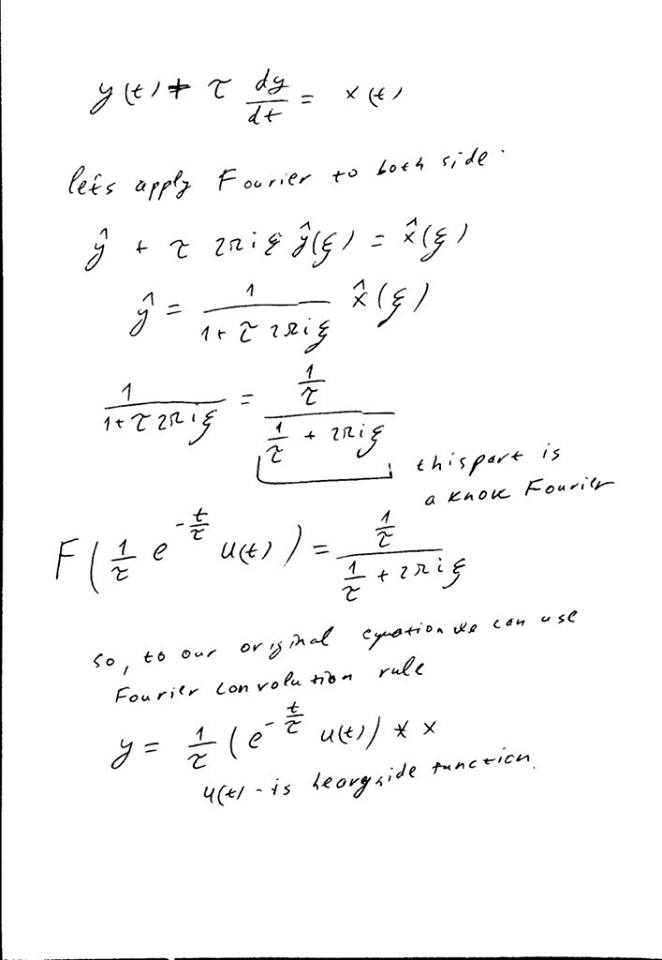

Lets use the above function to compute Impulse Response.

Therefore Impulse Response:
    $h(t) = 1/\tau (e^{-t/\tau}u(t))$

In [57]:
def impulse_response_function(t):
    h = np.zeros(len(t));
    h[t>0] = 1/tau * np.exp((-1/tau)*t[t>0]);
    return h;

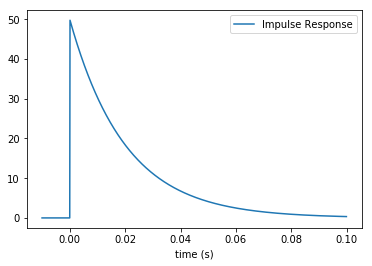

In [58]:
h_t = impulse_response_function(t);
plt.plot(t,h_t, label = 'Impulse Response');
plt.xlabel('time (s)')
plt.legend()

## 1-(c)

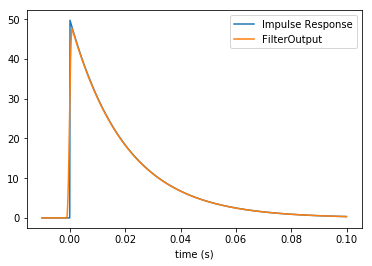

In [59]:
plt.plot(t,h_t, label = 'Impulse Response');
plt.plot(t,h_t_fo, label = 'FilterOutput');
plt.xlabel('time (s)')
plt.legend()

Here, the Impulse Response from 1-b and FilterOutput function is ploted together and we can see that both of them looks almost same. This is rough approximation of Exponential Distribution.

## 1-(d)

In [60]:
def x_t(t):
    if 0 <= t and t <= 0.1:
        return 1;
    else:
        return 0;
    return y;

As asked in quesiont, I added a new function x_t which returns 1 if time t is in range  of 0:0.1 seconds.

In [61]:
t=np.arange(-.02,.2,dt);
y_t = filterOutput(t,x_t);

Text(0.5, 0, 'time (s)')

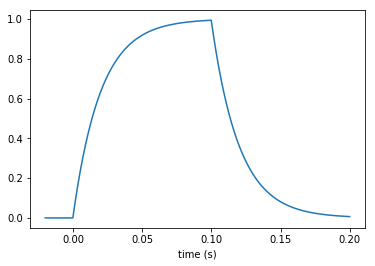

In [63]:
plt.plot(t, y_t);
plt.xlabel('time (s)')

As shown above plot, it is a current clamp output

We now study the frequency properties of this system.

**Question 2:**

 - (a) Compute the frequency response (Fourier transform of the impulse response) using the routine scipy.signal.freqs (check the documentation for the appropriate definition of the arguments), for a frequency axis ranging from 1Hz to 1000Hz. Note that the angular frequency $\omega$ corresponds to $2\pi f$, where $f$ is the freqency in Hz.
 - (b) From the lecture retrieve the analytical expression of the frequency response
 - (c) Plot and compare the modulus of both frequency responses obtained in (a) and (b)
 - (d) Compute the output of the system for input $\cos(2\pi f_0 t)$ for $f_0=1,10,100,1000Hz$, for a time ranging from $0$ to $3s$, estimate the amplitude of the response in each case (use $(max(y) - min(y))/2$ over e.g. the last period of the computed output). Which aspect of the frequency response this amplitude should reflect? Check consistency of the results with (c).

## 2-(a)

We found the Fourier transform of the impulse response in 1-b which is:

$\hat{h} = \frac{1}{1 + \tau 2 \pi i \xi}$ Lets say $p = 2 \pi i \xi$

And it is equal to:

$\frac{Y(p)}{X(p)} = H(p) = \frac{1}{1 + \tau p} = \frac{\sum^N_{k=0}b_{k}p^k}{\sum^M_{k=0}a_{k}p^k}$

From this equation we can see that:
$\\a_0 = \tau \\ a_1 = 1\\b_0=1$

In [64]:
# declared array according to the above statement
a = [tau, 1.];
b = [1.];

# I am generating Frequency array from 1 to 1000 Hz. And to get angular frequency i multiplied by 2pi
w_freq = 2*np.pi*np.logspace(0, 3, 1000); 

# I used freqs function to generate amplitudes for the given 
w, h = freqs(b, a, worN=w_freq);

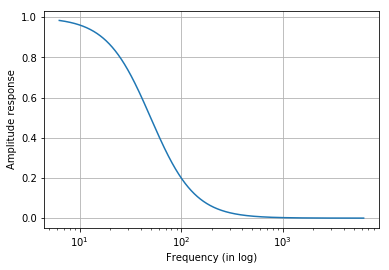

In [66]:
plt.semilogx(w, h);
plt.xlabel('Frequency (in log)');
plt.ylabel('Amplitude response');
plt.grid();
plt.show();

## 2-(b)

As shown before the analytical expression of impulse response is: 

$\hat{h} = \frac{1}{1 + \tau 2 \pi i \xi}$ Lets say $p = 2 \pi i \xi$

In [68]:
w_freq = np.logspace(0, 3, 1000);

# using the above mentioned equation
y = 1 / (1 + tau * 2 * np.pi * w_freq *1j);

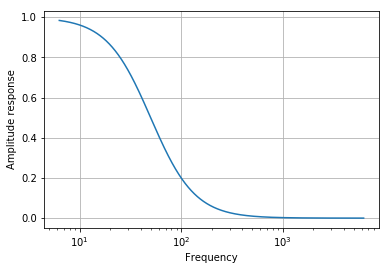

In [69]:
plt.semilogx(w, y);
plt.xlabel('Frequency');
plt.ylabel('Amplitude response');
plt.grid();
plt.show();

## 2-(c)

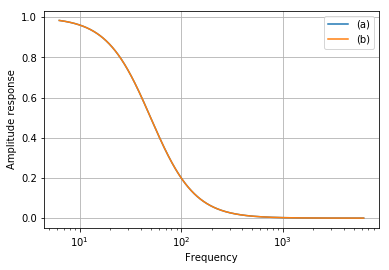

In [22]:
plt.semilogx(w, h, label = '2-(a)');
plt.semilogx(w, y, label = '2-(b)');
plt.xlabel('Frequency');
plt.ylabel('Amplitude response');
plt.grid();
plt.legend();
plt.show();

The comparison of exercies 2-a and 2-b looks very much same with each other.

## 2-(d)

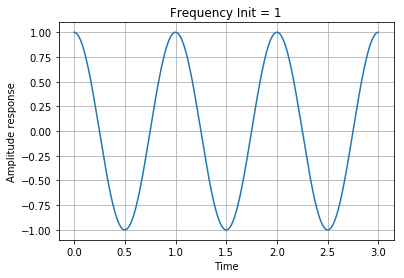

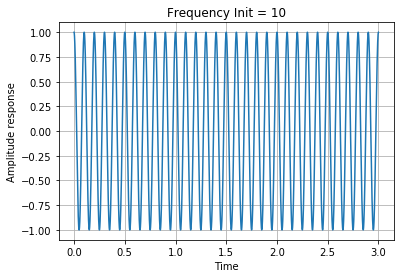

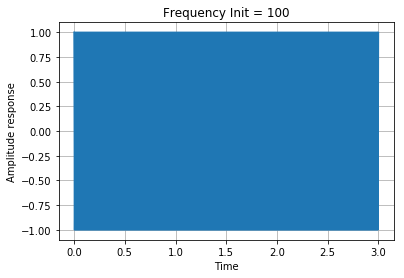

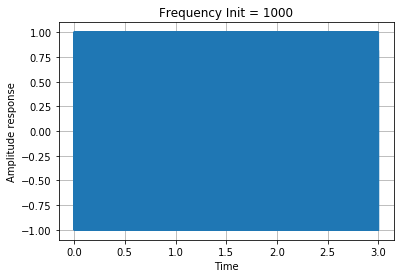

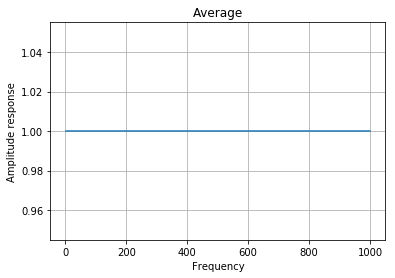

In [23]:
f0 = np.array([1, 10, 100, 1000]);
t = np.arange(0,3,dt);
y = np.zeros([len(f0), len(t)]);
for i in range(len(f0)):    
    y[i] = np.cos(2 * np.pi * f0[i] * t);    
    plt.plot(t, y[i]);
    plt.title('Frequency Init = {}'.format(f0[i]));
    plt.xlabel('Time');
    plt.ylabel('Amplitude response');
    plt.grid();
    plt.show();
    
y_average = np.zeros(len(f0));

for i in range(len(f0)):
    y_average[i] = (max(y[i,30000-int(1/dt):30000]) - min(y[i,30000-int(1/dt):30000]))/2;
    
plt.plot([1, 10, 100, 1000],y_average);
plt.title('Average');
plt.xlabel('Frequency');
plt.ylabel('Amplitude response');
plt.grid();
plt.show();

Here, we can see cosine signal with different frequencies and the amplitude is same in each case (only the frequency is changing).

# Part 2: Digital filters

We will now approximate the behavior of the above continuous time system based on the discretization of the impulse response.

## Finite impulse response filter
We want to define an discrete time LTI system based on a finite length discretization of continuous time impulse response. 

**Question 3:**

 - (a) Use question 1 to create a sequence $h_d$ of N values resulting from the sampling of the empirically estimated impulse response $h(t)$ (i.e. the response to a spike(t)) of the continuous time system at times $t=0,dt,2dt,...,(N-1)dt$ with N =200 and dt=.0001
 - (b) Consider the discrete time LTI system with impulse response $g[k]=\begin{cases}h_d[k]&, \text{if}\quad k\in [0\dots N-1]\\0 &,\text{otherwise.}\end{cases}$. Check the lecture and the documentation of the function scipy.signal.lfilter to define the routine that computes the M values of the output of this system given M values of the input (all values taken by inputs and outputs before those are assumed to be zero).
 - (c) The above discretized system approximates the contiuous time system of questions 1-2 by replacing continuous time convolution by discrete time convolution. Using approximation of integrals based on rectangles of width $dt$ (as done in the lectures), explain how the output of the discretized system can be rescaled to approximately match the range of values achieved by the continuous time system.
 - (d) Use the routine defined in (b) to compute a discretize response for the current clamp experiment of question 1(d). For that you will use the response to the discretized input sampled at dt=.001. Compare the discretized response to the response computed in question 1(d).
 - (e) Use the routine *scipy.signal.freqz* to compute the frequency response of the discrete time LTI system defined above. Compare this response to the response of the continuous time system computed in questionn 2, by converting normalized frequencies to physical frequencies (in Hz) by multiplying them by the sampling frequency $1/dt$. Note again that the frequency axis of freqz is given in pulsation ($2\pi$ times normalized frequency)
 - (f) Increase N to observe how the discretized system response gets closer to the original continuous time system (reproduce c-d plots with selected values of N.

## 3-(a)

Here, We are only sampling the first 200 times with dt = 0.0001

In [116]:
dt = 0.0001;
N = 200;
t = np.arange(0, N*dt, dt);

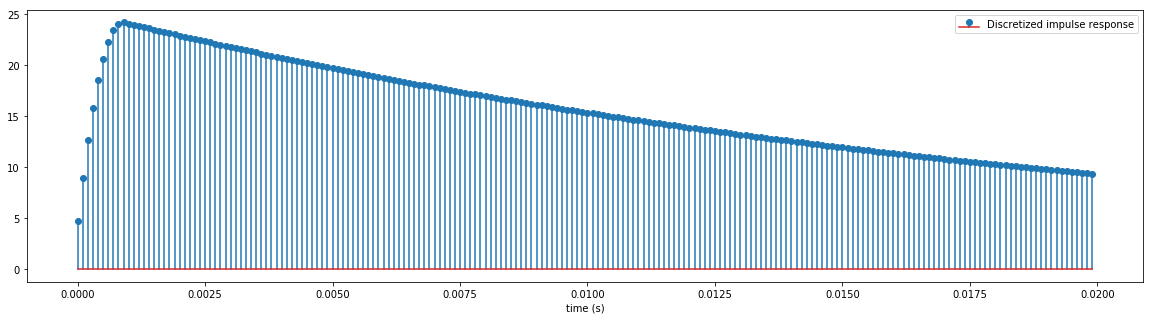

In [117]:
spike = lambda t: spikeWaveform(t,T);
h_t = filterOutput(t, spike);
plt.figure(figsize=(20,5));
plt.stem(t, h_t, label = 'Discretized impulse response');
plt.xlabel('time (s)')
plt.legend()


As expected, we only sampled first 200 times so that we can see a cutted finish at 0.02 seconds. So, we would also expect a not-finished response.

## 3-(b)

Below is the LTI function, that returns M output given M input (which is spike(t) in this case).

In [118]:
def LTI(M_input, h_t):
    
    # I generated a g(k) impulse response out of h(k) impulse response.
    b = np.zeros(len(M_input));
    b[0:len(h_t.flatten())] = h_t.flatten();    
    
    # to get IIR, we need to give a as 1
    a = np.array([1.]);
    
    # given M input which is spike(t)
    y = lfilter(b, a, M_input);
    return y;

## 3-(c)

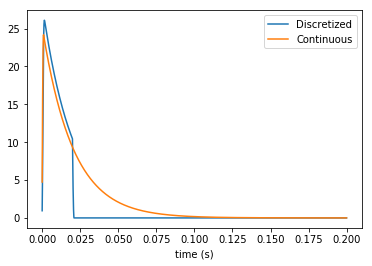

In [119]:
m = 2000;
dt = 0.0001;
t_ = np.arange(0, m*dt, dt);
M_input = spike(t_);
y = LTI(M_input, h_t);

spike = lambda t: spikeWaveform(t,T);
h_t_fo = filterOutput(t_, spike);

plt.plot(t_,y/5000, label='Discretized');
plt.plot(t_,h_t_fo, label='Continuous');
plt.legend();
plt.xlabel('time (s)');

When we take a very small dt and get the area of the small section, it is actually very close approximation to curved area. Because the dt is small small that it would actually look like a curve as shown in 3-(a). And that is what integral is doing suming all the small sections together to get the are while dt goes as close to 0 as possible. 

## 3-(d)

First, I sampled 100 Impulse response to generate $h_d$

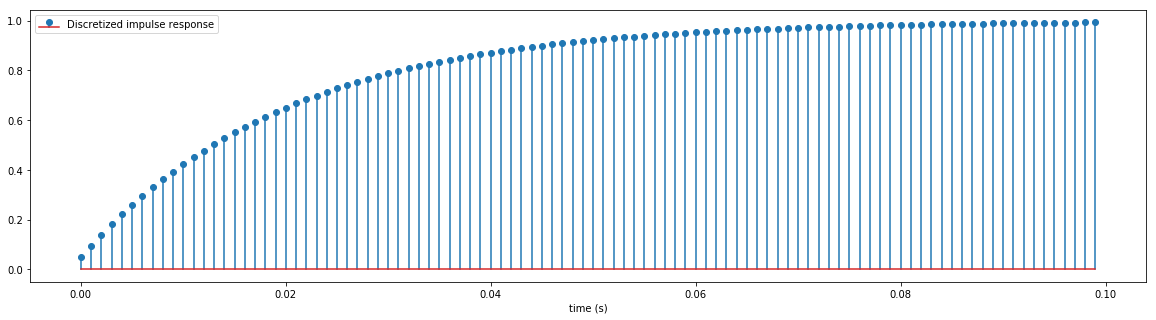

In [100]:
dt = 0.001;
N = 100;
t_3d = np.arange(0, N*dt, dt);
h_t_cc = filterOutput(t_3d, x_t);

plt.figure(figsize=(20,5));
plt.stem(t_3d, h_t_cc, label = 'Discretized impulse response');
plt.xlabel('time (s)')
plt.legend()

In [101]:
m = 2000;
dt = 0.001;
t_3d = np.arange(0, m*dt, dt);
M_input = spike(t_3d);

# Here I am using sampled impulse response of current clamp
b = np.zeros(len(M_input));
b[0:len(h_t_cc.flatten())] = h_t_cc.flatten();    

# to get IIR, we need to give a as 1
a = np.array([1.]);

# given M input which is spike(t)
y_3d = lfilter(b, a, M_input);

y_1d = filterOutput(t_3d,x_t);

Text(0.5, 0, 'time (s)')

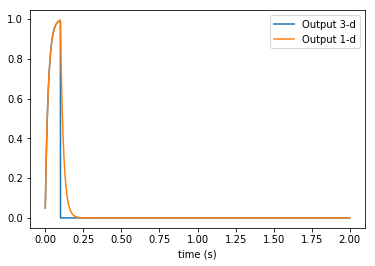

In [102]:
plt.plot(t_3d,y_3d*dt, label='Output 3-d');
plt.plot(t_3d,y_1d, label='Output 1-d');
plt.legend();
plt.xlabel('time (s)')

As we can see, there is an early finish in sampled impulse response.

## 3-(e)

In [103]:
m = 2000;

# I generated a g(k) impulse response out of h(k) impulse response.
b = np.zeros(m);
b[0:len(h_t.flatten())] = h_t.flatten();    

# to get IIR, we need to give a as 1
a = np.array([1.]);

# I used freqz function to generate frequency and amplitude using the above declared a and b.
w_3e, h_3e = freqz(b, a);

In [104]:
a = [tau, 1.];
b = [1.];
w_freq = 2*np.pi*np.logspace(0, 3, 1000);
w, h = freqs(b, a, worN=w_freq);

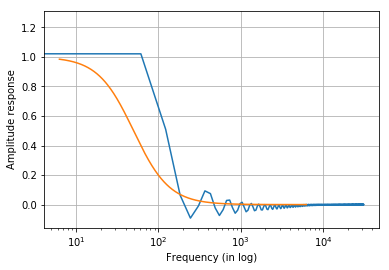

In [105]:
plt.semilogx(w_3e*10000,h_3e/(2*pi*400), label = 'Frequency FIR');
plt.semilogx(w, h, label = 'Frequency Continuous');
plt.xlabel('Frequency (in log)');
plt.ylabel('Amplitude response');
plt.grid();
plt.show();

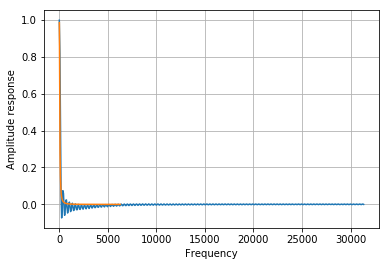

In [106]:
plt.plot(w_3e*10000, h_3e/(2*pi*500), label = 'Frequency FIR');
plt.plot(w, h, label = 'Frequency Continuous');
plt.xlabel('Frequency');
plt.ylabel('Amplitude response');
plt.grid();
plt.show();

As shown above, we can see similar frequency plot but there is a little noise in the frequency FIR.

## 3-(f)

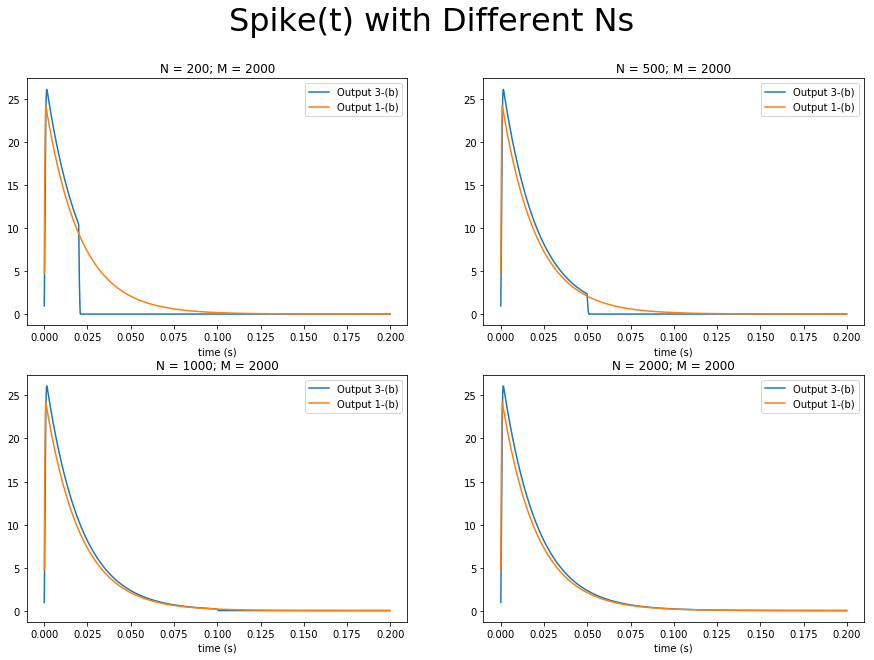

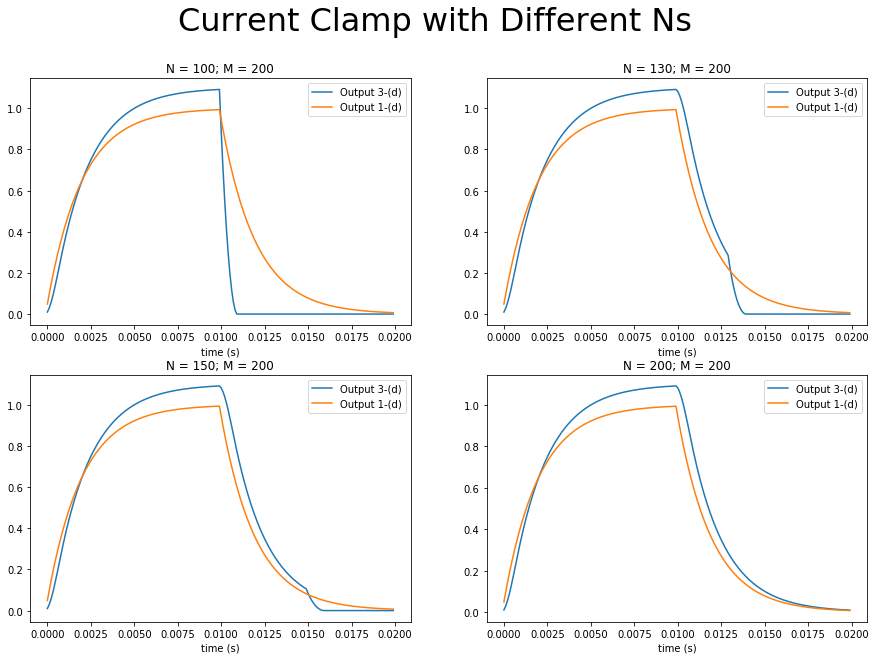

In [121]:
N_arr = np.array([200, 500, 1000, 2000]);

plt.figure(figsize=(15,10));
plt.suptitle('Spike(t) with Different Ns', fontsize = 32);

for i in range(len(N_arr)):
    
    dt = 0.0001;
    
    t_ = np.arange(0, N_arr[i]*dt, dt);
    spike = lambda t: spikeWaveform(t,T);
    h_t = filterOutput(t_, spike);    
    
    m = 2000;
    t_ = np.arange(0, m*dt, dt);
    M_input = spike(t_);
    y = LTI(M_input, h_t);
    
    spike = lambda t: spikeWaveform(t,T);
    h_t_fo = filterOutput(t_, spike);

    ax = plt.subplot(2,2,i+1);
    plt.plot(t_, y/5000, label='Output 3-(b)');
    plt.plot(t_, h_t_fo, label='Output 1-(b)');
    plt.title('N = {}; M = {}'.format(N_arr[i], m));
    plt.legend()
    plt.xlabel('time (s)')
    
N_arr = np.array([100, 130, 150, 200]);
plt.figure(figsize=(15,10));
plt.suptitle('Current Clamp with Different Ns', fontsize = 32);

for i in range(len(N_arr)):
    dt = 0.001;
    t_3d = np.arange(0, N_arr[i]*dt, dt);
    h_t_cc = filterOutput(t_3d, x_t);
    
    m = 200;    
    t_3d = np.arange(0, m*0.0001, 0.0001);
    M_input = spike(t_3d);

    # Here I am using sampled impulse response of current clamp
    b = np.zeros(len(M_input));
    b[0:len(h_t_cc.flatten())] = h_t_cc.flatten();    

    # to get IIR, we need to give a as 1
    a = np.array([1.]);

    # given M input which is spike(t)
    y_3d = lfilter(b, a, M_input);

    y_1d = filterOutput(t_3d,x_t);

    ax = plt.subplot(2,2,i+1);
    plt.plot(t_3d, y_3d/5000, label='Output 3-(d)');
    plt.plot(t_3d, y_1d, label='Output 1-(d)');
    plt.title('N = {}; M = {}'.format(N_arr[i], m));
    plt.legend()
    plt.xlabel('time (s)')

As we increase the N number, we get closer to the continuous plot

## Infinite impluse response filter

Based on lectures and the above question 1, we know that for our synpase system, if we discretize the analytic expression of the continuous time impulse response at multiples of sampling period $dt$, the resulting sequence takes the form 

\begin{equation}
h_d[k]=\begin{cases}\alpha \rho^k\,, & k\geq 0\\ 0\,,&\text{otherwise} \end{cases}
\end{equation}

We use this property to define an discrete time approximation of the system with infinite length response. This implies that the output computation will rely on a difference equation with a feedback term involving the past output values.

**Queston 4:**

 - (a) Give the expression of $\alpha$ and $\rho$ as a function of $\tau$ (refer to the lecture/homeworks if needed, but this is immediate using question 1).
 - (b) Based on developments shown in the lecture, show that such an $h_d$ is the impulse response of the difference equation (with input $x$ and output $y$)
$$
y[n]=\rho y[n-1]+\alpha x[n]
$$

 - (c) Use the lfilter function to implement this filter for the numerical values of our problem.
 - (d) Reproduce the questions 3.c-e with this new LTI sytem.
 - (e) Check how the approximation deteroriates (current clamp response and frequency response) when we use a coarser sampling period (dt=5ms,10ms).


## 4-(a)

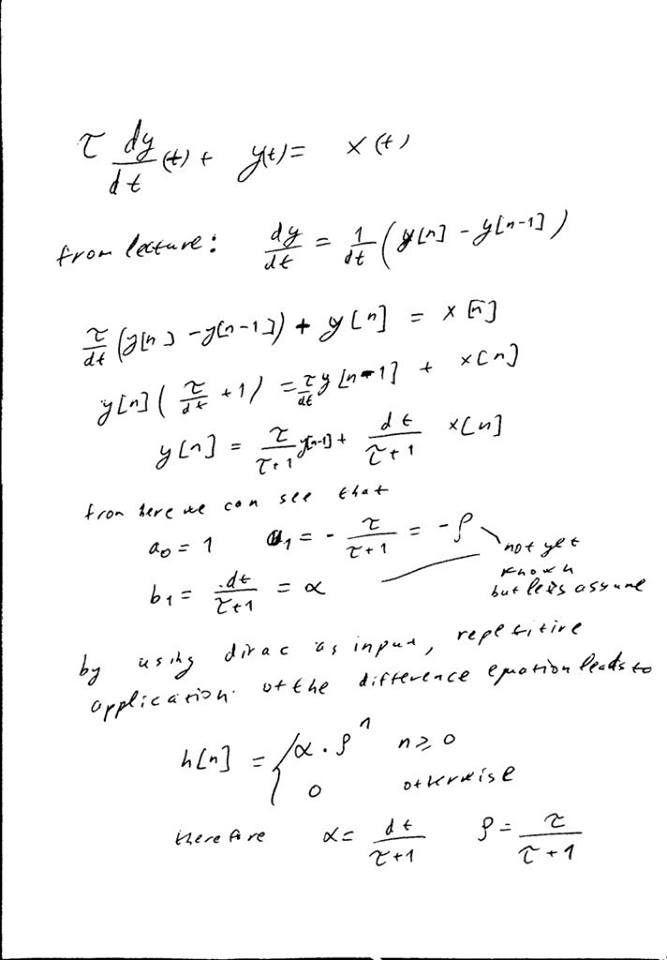

## 4-(b)

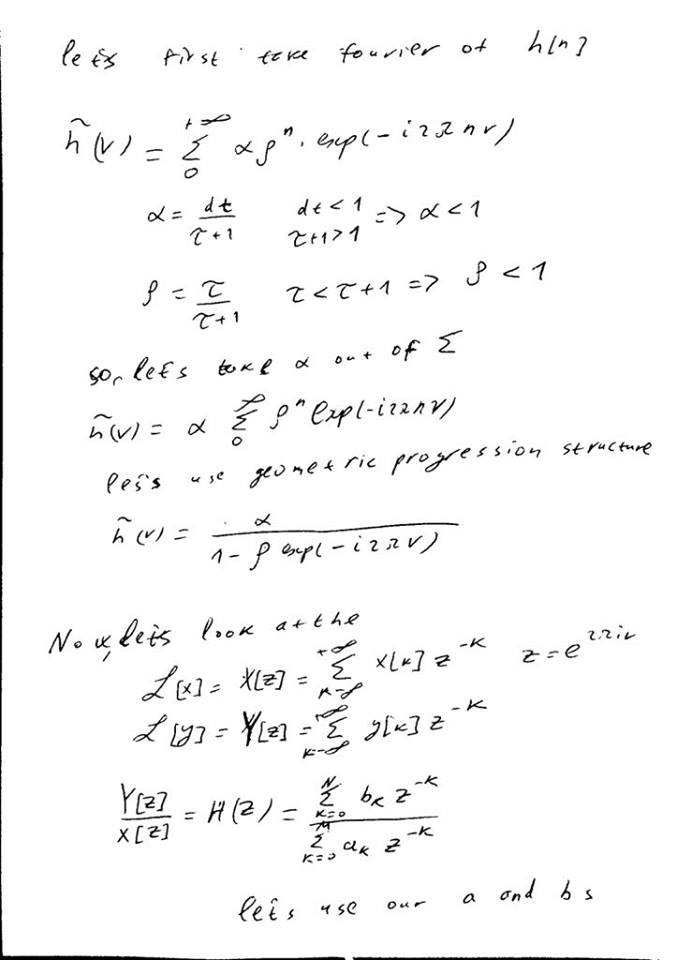

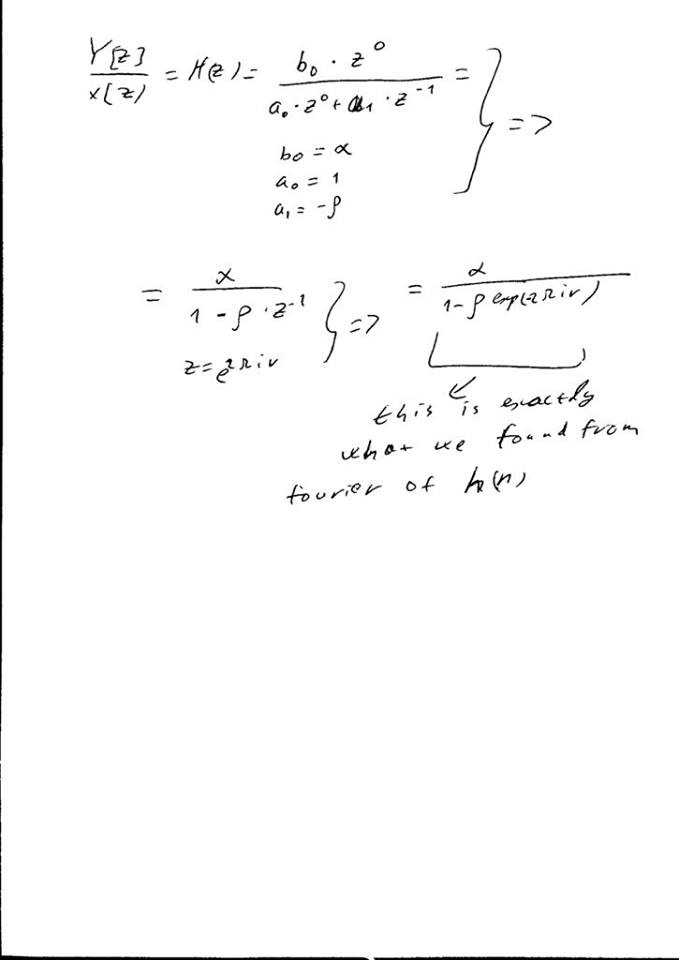

## 4-(c)

In [123]:
tau = 0.02;
dt = 0.001
t = np.arange(-0.1, 1000*dt, dt);

# I am initializing b and a with values above declared
b = np.array([dt/(tau + dt)])
a = np.array([1., -tau/(tau + dt)]);

# I am using lfilter to generate impulse response using input which is spike(t)
h_d_iir = lfilter(b, a, spike(t));

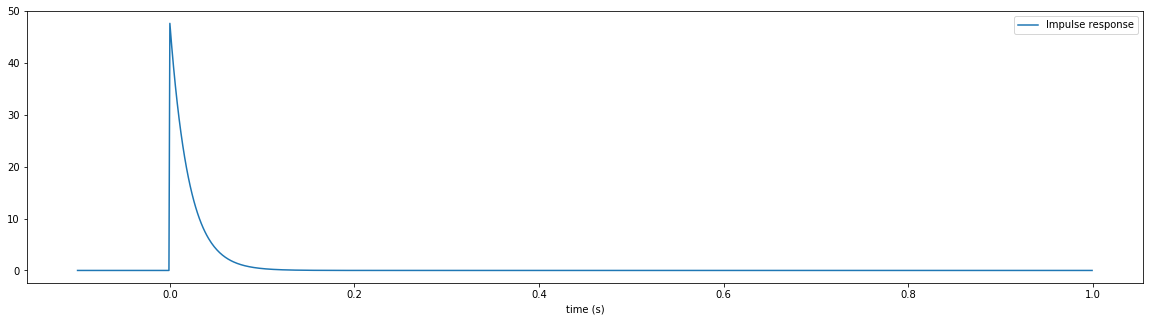

In [124]:
plt.figure(figsize=(20,5));
plt.plot(t, h_d_iir, label = 'Impulse response');
plt.xlabel('time (s)')
plt.legend()

## 4-(d)

In [37]:
tau = 0.02;
dt = 0.001
t = np.arange(-0.1, 1000*dt, dt);

# I am initializing b and a with values above declared
b = np.array([dt/(tau + dt)])
a = np.array([1., -tau/(tau + dt)]);
h_d_iir = lfilter(b, a, spike(t));

h_t_cont_spike = filterOutput(t, spike);


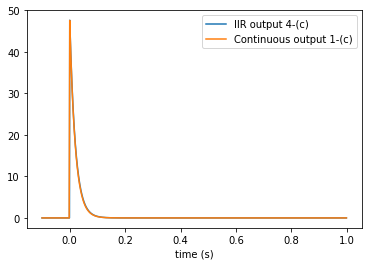

In [38]:
plt.plot(t, h_d_iir, label='IIR output 4-(c)');
plt.plot(t,h_t_cont_spike, label='Continuous output 1-(c)');
plt.legend();
plt.xlabel('time (s)');

As can be seen from above plot, the IIR is very similar to the continuous ouput from 1-c

In [39]:
t = np.arange(-0.1, 1000*dt, dt);

# I am initializing b and a with values above declared
b = np.array([dt/(tau + dt)])
a = np.array([1., -tau/(tau + dt)]);

# I am generating x input array for the current clamp experiment using x_t function I declared before
x_t_arr = np.zeros(len(t));
for i in range(len(t)):
    x_t_arr[i] = x_t(t[i]);
    
# I am using lfilter to generate impulse response using input which is x_t array
h_d_iir = lfilter(b, a, x_t_arr);

y_1d = filterOutput(t,x_t);

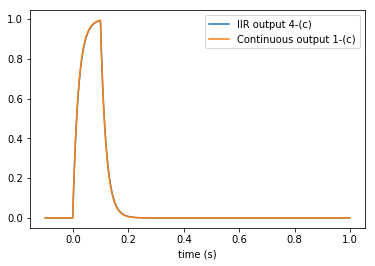

In [40]:
plt.plot(t, h_d_iir, label='IIR output 4-(c)');
plt.plot(t, y_1d, label='Continuous output 1-(c)');
plt.legend();
plt.xlabel('time (s)');

In [41]:

# I am initializing b and a with values above declared
b = np.array([dt/(tau + dt)]);
a = np.array([1., -tau/(tau + dt)]);

w_4e, h_4e = freqz(b, a);

In [42]:
a = [tau, 1.];
b = [1.];
w_freq = 2*np.pi*np.logspace(0, 3, 1000);
w, h = freqs(b, a, worN=w_freq);

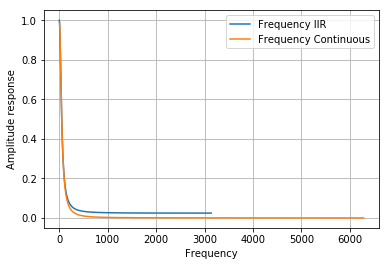

In [43]:
plt.plot(w_4e*1000, h_4e, label='Frequency IIR');
plt.plot(w, h, label='Frequency Continuous');
plt.xlabel('Frequency');
plt.ylabel('Amplitude response');
plt.grid();
plt.legend();
plt.show();

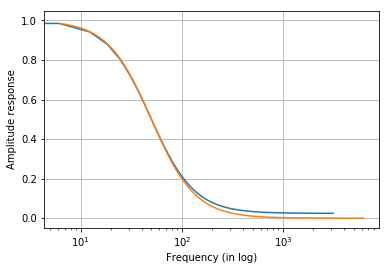

In [44]:
plt.semilogx(w_4e*1000, h_4e, label='Frequency IIR');
plt.semilogx(w, h, label='Frequency Continuous');
plt.xlabel('Frequency (in log)');
plt.ylabel('Amplitude response');
plt.grid();
plt.show();

## 4-(e)

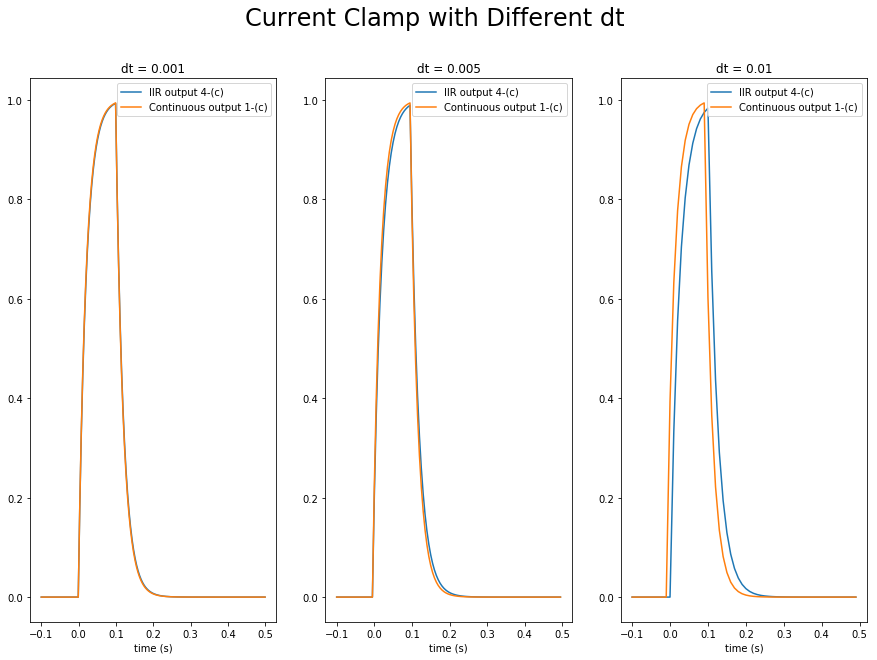

In [45]:
dt_array = np.array([0.001, 0.005, 0.01]);

plt.figure(figsize=(15,10));
plt.suptitle('Current Clamp with Different dt', fontsize = 24);

for i in range(len(dt_array)):    
    
    dt = dt_array[i];
    
    t = np.arange(-0.1, 0.5, dt);
    b = np.array([dt/(tau + dt)])
    a = np.array([1., -tau/(tau + dt)]);
    x_t_arr = np.zeros(len(t));
    for j in range(len(t)):
        x_t_arr[j] = x_t(t[j]);
    h_d_iir = lfilter(b, a, x_t_arr);

    y_1d = filterOutput(t,x_t);
    
    ax = plt.subplot(1,3,i+1);
    plt.plot(t, h_d_iir, label='IIR output 4-(c)');
    plt.plot(t, y_1d, label='Continuous output 1-(c)');
    plt.legend();
    plt.xlabel('time (s)');
    plt.title('dt = {}'.format(dt));

As we can see from the above plots, we lose accuracy as we generate with large delta t which follows the assumption.

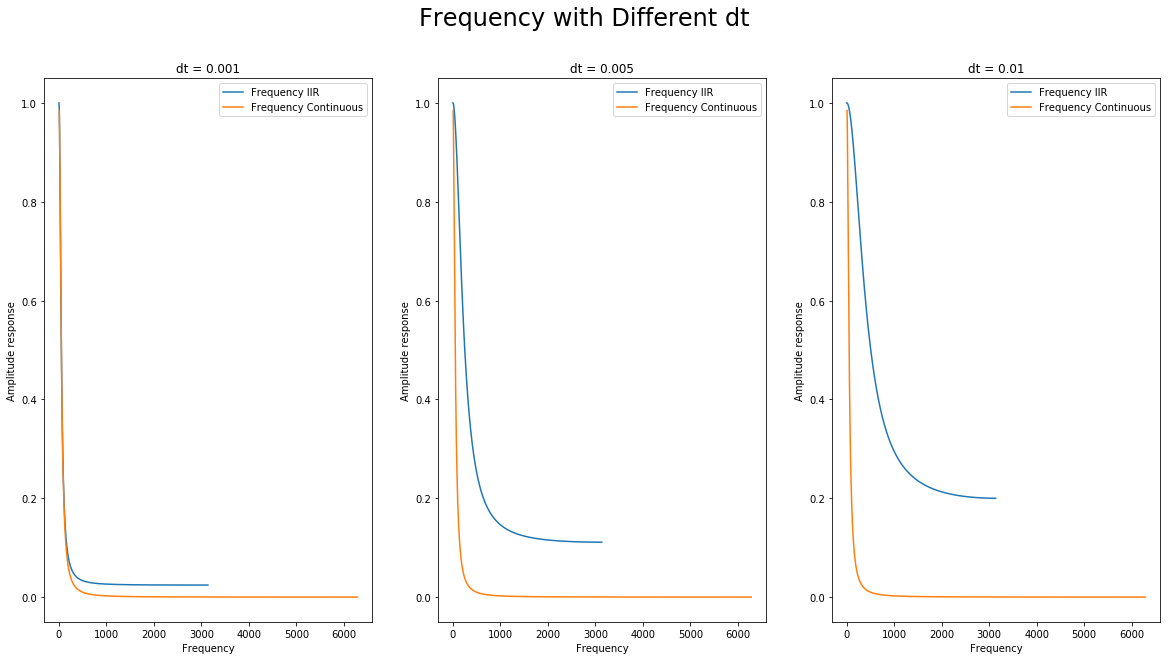

In [46]:
plt.figure(figsize=(20,10));
plt.suptitle('Frequency with Different dt', fontsize = 24);

for i in range(len(dt_array)):    
    
    dt = dt_array[i];
    
    b = np.array([dt/(tau + dt)]);
    a = np.array([1., -tau/(tau + dt)]);
    w_4e, h_4e = freqz(b, a);
    
    a = [tau, 1.];
    b = [1.];
    w_freq = 2*np.pi*np.logspace(0, 3, 1000);
    w, h = freqs(b, a, worN=w_freq);
    
    ax = plt.subplot(1,3,i+1);
    
    plt.plot(w_4e*1000, h_4e, label='Frequency IIR');
    plt.plot(w, h, label='Frequency Continuous');
    plt.xlabel('Frequency');
    plt.ylabel('Amplitude response');
    plt.title('dt = {}'.format(dt));
    plt.legend();

We can also see that the frequency is becoming worse as we increase the delta t